In [1]:
import pandas as pd
import numpy as np
import re
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt
import seaborn as sns

/Users/jonwells/miniconda3/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


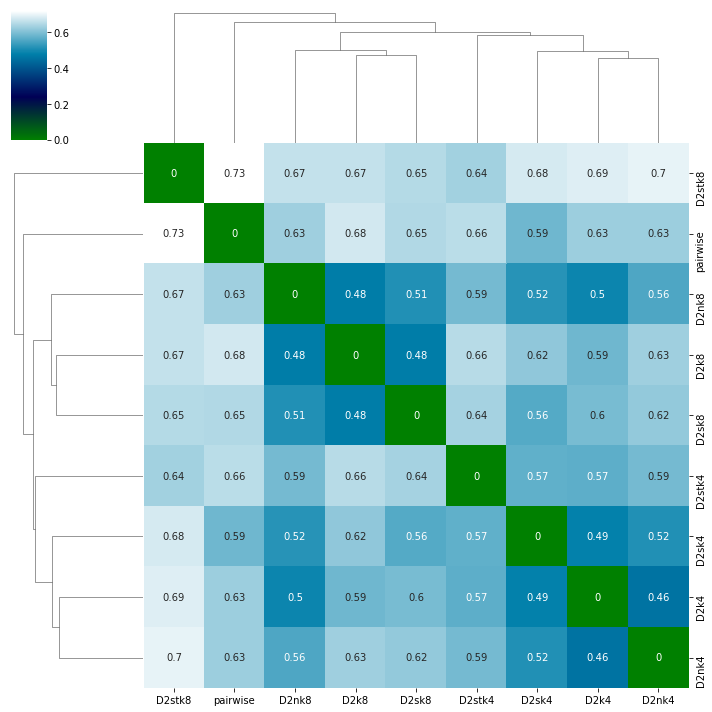

,value
variable,
D2nk8,4.459341
D2k4,4.522958
D2sk4,4.547844
D2sk8,4.714511
D2nk4,4.716789
D2k8,4.802664
D2stk4,4.922888
pairwise,5.201542
D2stk8,5.427971


In [2]:
rfdata = []
N = 2*(5709-3)
with open('../data/selection-analysis/D2_trees.nwk.rfdist') as infile:
    dims = (int(i) for i in infile.readline().split())
    for line in infile:
        rfdata.append([int(i)/N for i in line.split()[1:]])
rfdata = np.matrix(rfdata)

labels = ['D2k4', 'D2k8', 'D2nk4', 'D2nk8', 'D2sk4', 'D2sk8', 'D2stk4', 'D2stk8', 'pairwise']
df = pd.DataFrame(rfdata, columns=labels, index=labels)
g = sns.clustermap(df, cmap='ocean', annot=True)
plt.show()
df.reset_index().melt(id_vars='index').groupby('variable').sum().sort_values('value')

In [3]:
pairwise_df = pd.read_csv('../data/denovo_chr4_pairwise_needleman.txt', sep='\t', header=None).drop_duplicates()
pairwise_df.columns = ['p1', 'p2', 'pid']
pairwise_df['pid'] = 100 - pairwise_df['pid']
pairwise_df = pairwise_df.pivot('p1', 'p2', 'pid')
labels = list(pairwise_df.columns)
pairwise_mat = pairwise_df.to_numpy()
for i in range(len(labels)):
    for j in range(len(labels)):
        if pairwise_mat[i][j] != pairwise_mat[j][i]:
            val=min(pairwise_mat[i][j], pairwise_mat[j][i])
            pairwise_mat[i][j] = val
            pairwise_mat[j][i] = val
            
pairwise_df = pd.DataFrame(data=pairwise_mat,
                           index=labels,
                           columns=labels)
pairwise_mat = pairwise_df.to_numpy()

Now, we would like to see the relationship between chromosomal location and sequence identity. We will restrict ourselves to chromosome 4, which is 78,093,715 bp long.

In [4]:
tss_df = pd.read_csv('../data/gffs/denovo_chr4_augustus_finz.gff', sep='\t', header=None, comment='#').sort_values([1])
tss_df = tss_df.loc[tss_df[2] == 'start_codon']
tss_df['gene'] = tss_df[8].apply(lambda x: 'denovo_chr4_' + re.match('Parent=(.+)', x).group(1))
tss = list(zip(tss_df['gene'], tss_df[3]))
tss = [i for i in tss if i[0] in list(pairwise_df.columns)]

In [5]:
print(tss_df)

                0         1            2         3         4  5  6  7  \
15225  Gaia_chr_4  AUGUSTUS  start_codon  57313131  57313133  .  +  0   
15252  Gaia_chr_4  AUGUSTUS  start_codon  57411621  57411623  .  -  0   
15242  Gaia_chr_4  AUGUSTUS  start_codon  57390956  57390958  .  +  0   
15192  Gaia_chr_4  AUGUSTUS  start_codon  57288339  57288341  .  +  0   
15177  Gaia_chr_4  AUGUSTUS  start_codon  57256050  57256052  .  +  0   
...           ...       ...          ...       ...       ... .. .. ..   
7598   Gaia_chr_4  AUGUSTUS  start_codon  42531614  42531616  .  +  0   
7595   Gaia_chr_4  AUGUSTUS  start_codon  42528652  42528654  .  -  0   
7627   Gaia_chr_4  AUGUSTUS  start_codon  42599393  42599395  .  -  0   
7609   Gaia_chr_4  AUGUSTUS  start_codon  42550660  42550662  .  +  0   
22847  Gaia_chr_4  AUGUSTUS  start_codon  74093694  74093696  .  -  0   

                     8                  gene  
15225  Parent=g1465.t1  denovo_chr4_g1465.t1  
15252  Parent=g1467.t1  denov

In [27]:
data = []
chromsize = 74498832  # chr4 is 78093716; chr15 is 7809371; denovo chr4 is 74498832
chromstart = int(0.3*chromsize)
window = 100000

for i in range(chromstart, chromsize, window):
    nexti = i + window
    row = []
    p1 = None
    for k in tss:
        if i <= k[1] < nexti:
            p1 = k[0]
            break
    for j in range(chromstart, chromsize, window):
        nextj = j + window
        p2 = None
        for k in tss:
            if j <= k[1] < nextj:
                p2 = k[0]
                break
        if p1 and p2:
            pairval = pairwise_df.loc[p1, p2]
            if pairval <= 100:
                row.append(pairval)
            else:
                row.append(100.0)
        else:
            row.append(100.0)                
    data.append(row)

data = np.asarray(data)
print(data)

[[100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 ...
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]]


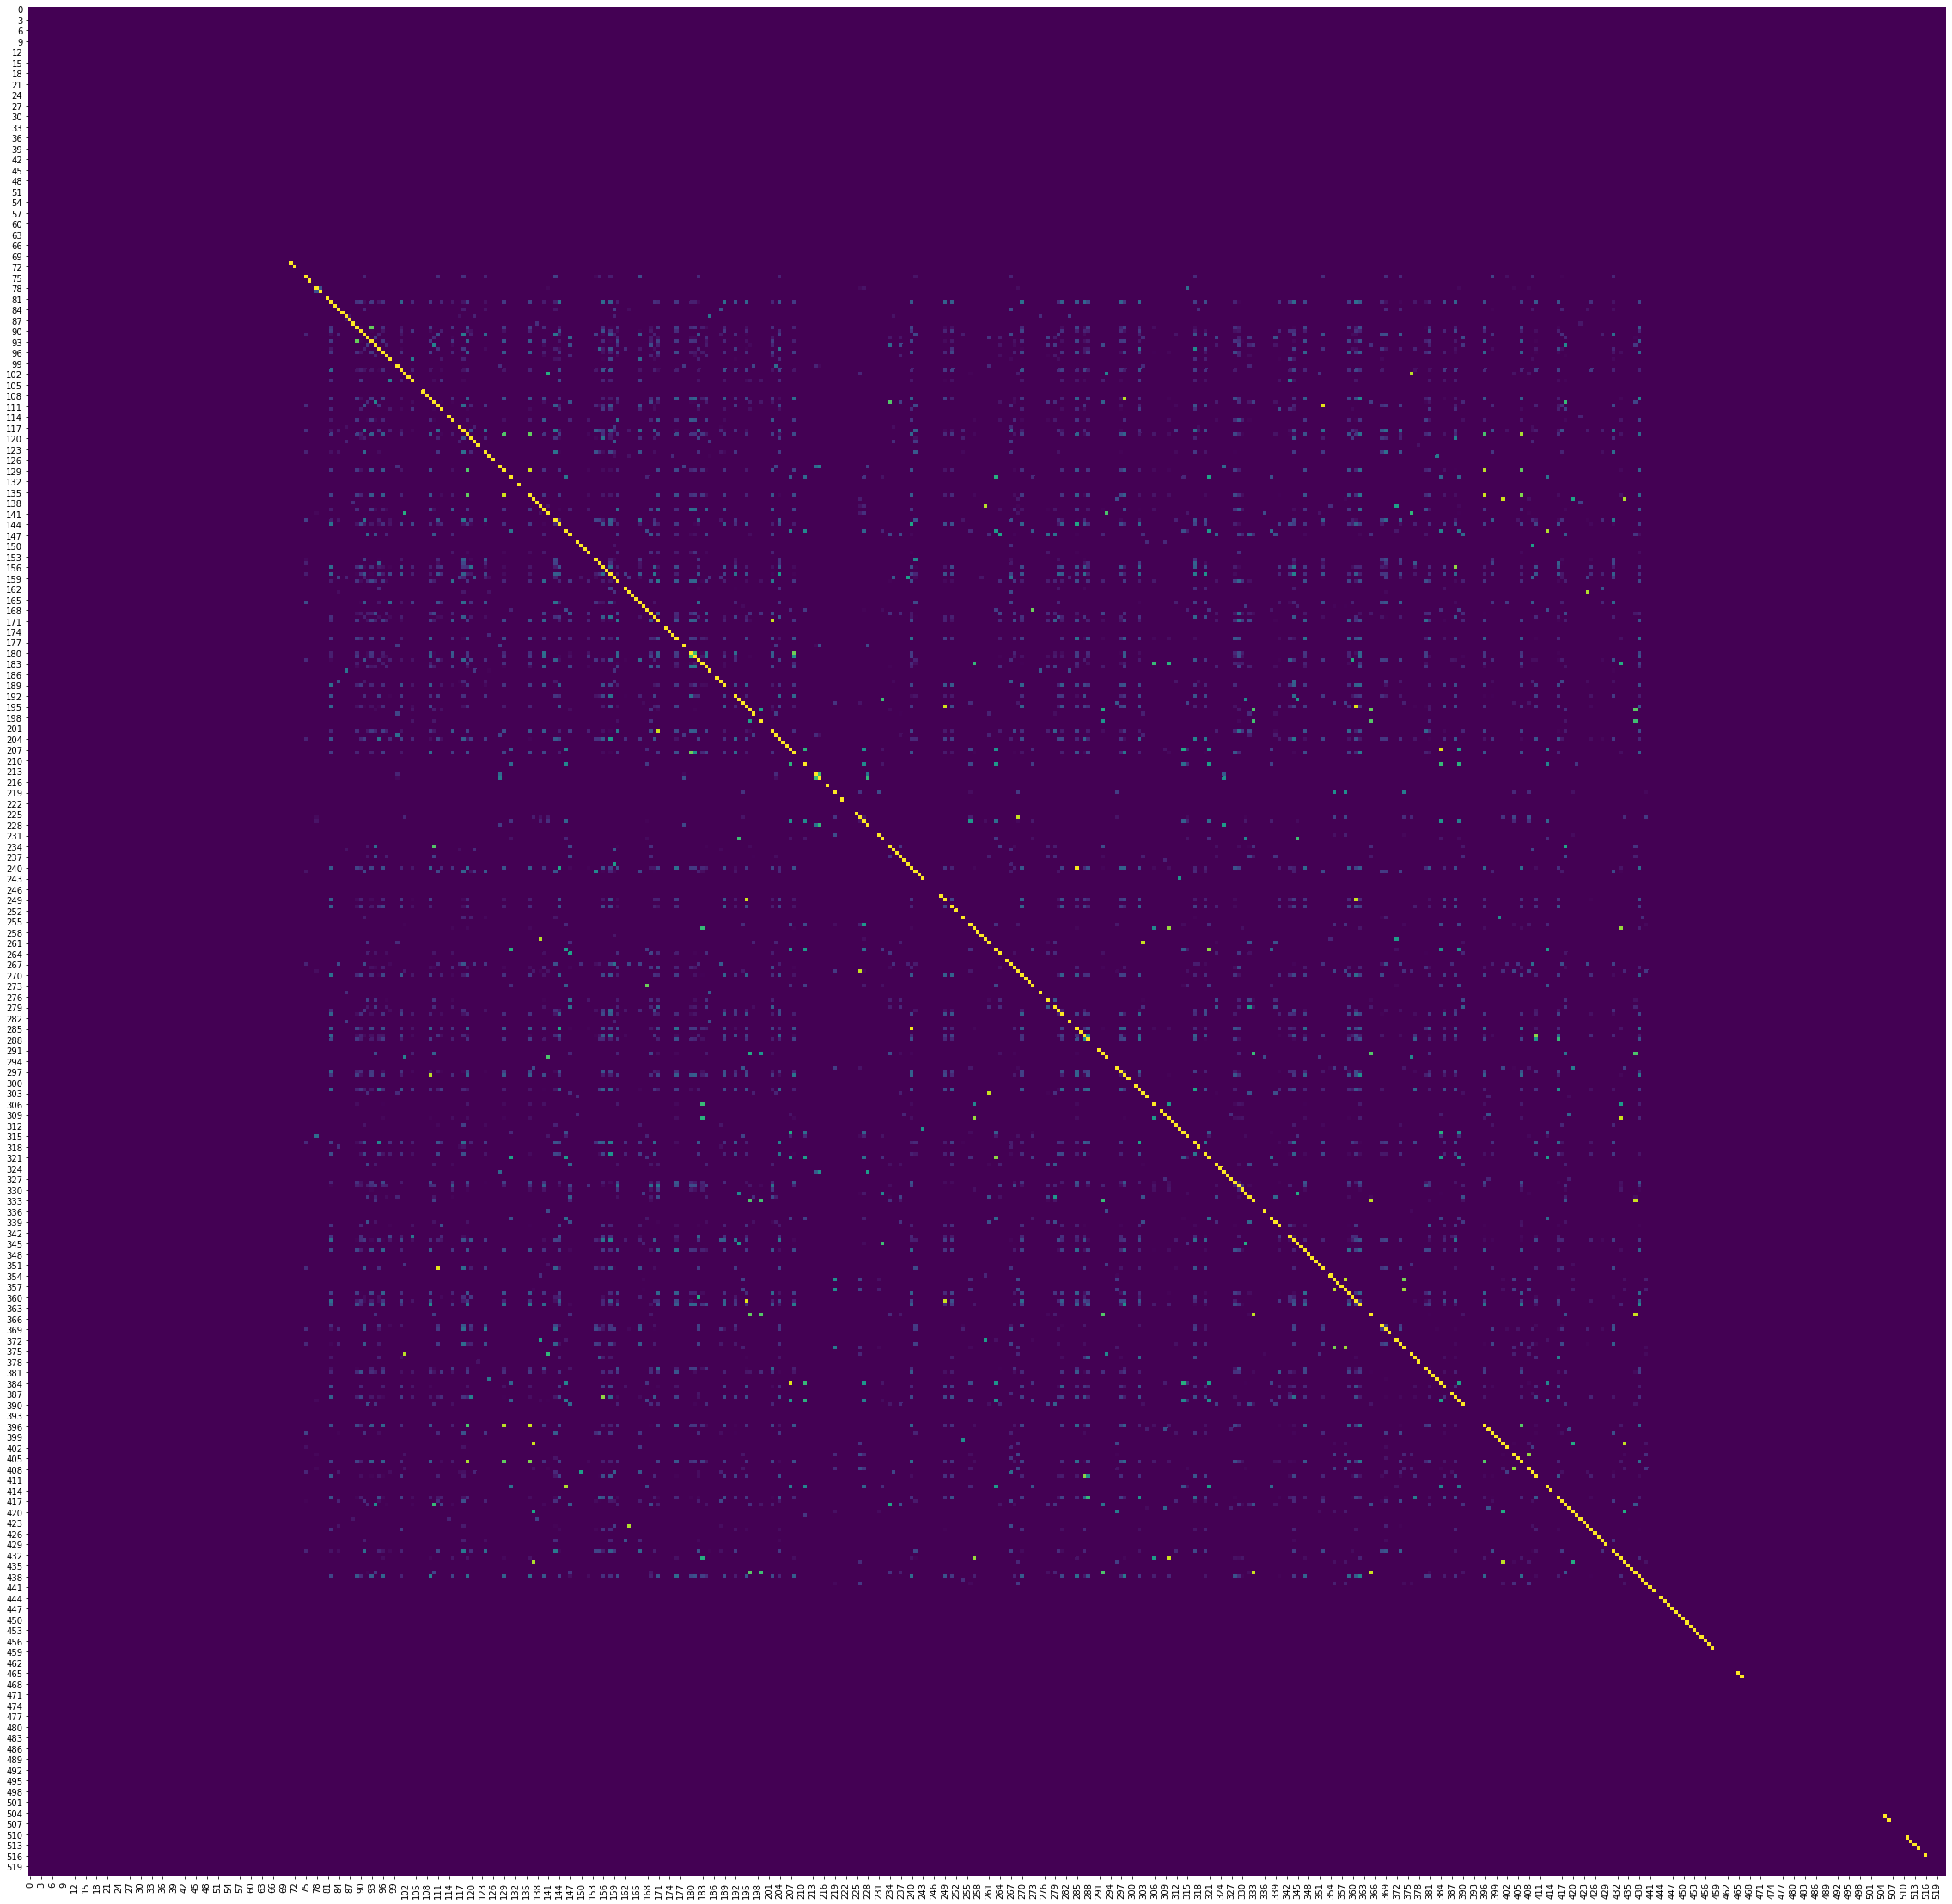

In [28]:
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(data,
            cmap='viridis_r',
            cbar=False, vmax=35)
plt.savefig('../figs/expressed_tss_heatmap.png')
plt.show()


In [8]:
# print(pairwise_df.shape)
tss_df2 = tss_df.loc[tss_df.gene.isin(pairwise_df.index)]
# print(tss_df2.shape)

for_corr = []
for i, igene in tss_df2.iterrows():
    for j, jgene in tss_df2.iterrows():
        if j <= i:
            continue
        if igene[6] == jgene[6]:
            orientation = 'same'
        else:
            orientation = 'inverted'
        seq_dist = pairwise_df.loc[igene['gene'], jgene['gene']]
        physical_dist = abs(igene[3] - jgene[3])
        for_corr.append((seq_dist, physical_dist, orientation))

In [19]:
dist_df = pd.DataFrame(for_corr, columns=['pairwise', 'dist', 'orientation'])
dist_df['dist'] = dist_df['dist']/1000.0
dist_df['pairwise'] = 100.0 - dist_df['pairwise']
print(dist_df)

        pairwise     dist orientation
0           30.2   98.490    inverted
1           24.6  165.362        same
2           31.2  102.798        same
3           30.3  134.178        same
4           33.9  128.222    inverted
...          ...      ...         ...
216148      55.7  144.519        same
216149      34.4  299.099        same
216150      72.1  292.815    inverted
216151      43.8  137.293    inverted
216152      69.7  124.856    inverted

[216153 rows x 3 columns]


NameError: name 'h' is not defined

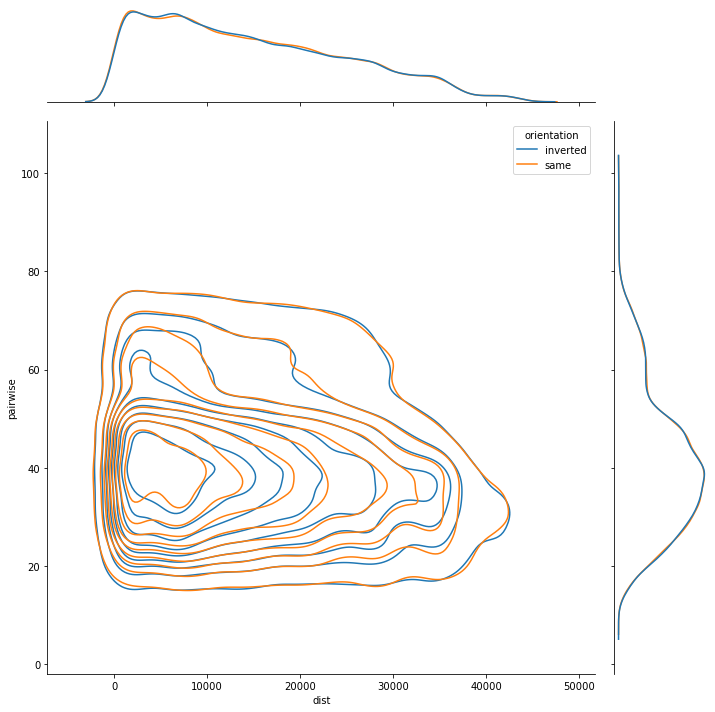

In [39]:
sns.jointplot(data=dist_df, x='dist', y='pairwise', hue='orientation', kind='kde', height=10)
h.set_axis_labels('distance between pair (kbp)', 'pairwise sequence identity (%)')
sns.despine()
plt.show()

In [38]:
print(stats.spearmanr(dist_df.pairwise, dist_df.dist))
print(stats.pearsonr(dist_df.pairwise, dist_df.dist))

SpearmanrResult(correlation=-0.1255197347627536, pvalue=0.0)
(-0.14395827961571905, 0.0)
